In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="Set2")

In [14]:
df = sns.load_dataset("titanic")
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Selección y eliminación justificada de variables

Durante la etapa inicial del análisis se realizó una depuración del conjunto de datos con el objetivo de eliminar redundancias, reducir ruido y evitar colinealidad entre las variables.
Este paso fue esencial para garantizar que el Análisis de Componentes Principales (PCA) reflejara únicamente la estructura subyacente de los datos relevantes.

class: Eliminada por redundante. Su información estaba ya representada en la variable pclass, que indica la clase del pasajero en formato numérico (1ª, 2ª o 3ª).

who: Variable categórica derivada de sex y age (“man”, “woman”, “child”). Fue descartada por duplicar información existente y generar dependencia artificial entre variables.

adult_male: Indicador booleano que combina sexo y edad. Se eliminó por la misma razón: es una variable compuesta y redundante.

deck: Eliminada por presentar más del 70 % de valores faltantes. Su imputación habría introducido un sesgo estadístico considerable.

embark_town: Contenía la misma información que embarked, expresada en texto. Se mantuvo únicamente embarked por ser una variable categórica más compacta.

alive: Versión textual de la variable survived. Se mantuvo únicamente la representación numérica (0 = no sobrevivió, 1 = sobrevivió).

alone: Derivada de las variables sibsp y parch (número de hermanos/esposos y padres/hijos a bordo). Dado que puede calcularse como (sibsp + parch == 0), fue eliminada por redundancia.


In [15]:
cols_to_drop = ['class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
df = df.drop(columns=cols_to_drop)

Tratamiento de valores faltantes

Antes de aplicar el PCA fue necesario completar los valores faltantes en algunas variables, para evitar errores y mantener la consistencia del conjunto de datos. Las variables que presentaban nulos fueron age y embarked, y en cada caso se aplicó un criterio distinto según el tipo de dato.

En la variable age, los valores faltantes se reemplazaron por la media aritmética de las edades registradas. Este método permite mantener la distribución general y no modifica de forma significativa la media ni la varianza del conjunto, algo importante para el PCA ya que este análisis se basa en la estructura de varianza entre las variables.

En el caso de embarked, se detectaron solo dos valores nulos. Dado que es una variable categórica, se completaron con la moda, que corresponde al puerto 'S' (Southampton), el más frecuente en el dataset. De esta manera se preservó la coherencia de la información original sin afectar la distribución general de los datos.

In [16]:
df['age'] = df['age'].fillna(df['age'].mean())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

Codificacion de variables categoricas y estandarizacion

Una vez completado el tratamiento de valores faltantes, se procedió a convertir las variables categóricas en variables numéricas para que pudieran ser utilizadas en el PCA. En particular, las variables sex y embarked fueron transformadas mediante el método one-hot encoding, utilizando la función get_dummies() de pandas.

Esto generó nuevas columnas binarias (sex_male, embarked_Q, embarked_S) que toman valores 0 o 1 según la categoría correspondiente. La categoría embarked_C no se incluyó, ya que puede deducirse de las demás y su exclusión evita colinealidad entre variables.

Finalmente, se realizó la estandarización de todas las variables numéricas mediante la clase StandardScaler de scikit-learn. Este proceso ajustó los datos para que cada variable tenga media cero y varianza unitaria, asegurando que todas contribuyan en igual medida al cálculo de los componentes principales.

In [17]:
df = pd.get_dummies(df, columns=['sex', 'embarked'], drop_first=True)
df = df.astype({col: int for col in df.select_dtypes('bool').columns})

In [18]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos las variables finales para el PCA
features = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q', 'embarked_S']
X = df[features]

# Escalamos (media 0, varianza 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos a DataFrame para ver el resultado (opcional)
import pandas as pd
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

X_scaled_df.head()


,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.737695,-0.307562,0.615838
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,-1.355574,-0.307562,-1.623803
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,-1.355574,-0.307562,0.615838
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,-1.355574,-0.307562,0.615838
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,0.737695,-0.307562,0.615838


Aplicacion de PCA y analisis de variancia explicada

Con el conjunto de datos ya limpio, numérico y estandarizado, se aplicó el Análisis de Componentes Principales (PCA) utilizando la librería scikit-learn. Este método permite reducir la dimensionalidad del dataset y detectar patrones entre las variables conservando la mayor parte posible de la información original.

Al aplicar el PCA se obtuvo el porcentaje de varianza explicada por cada componente, lo que indica cuánta información del conjunto total de variables está representada en cada eje principal. Las dos primeras componentes (PC1 y PC2) concentraron la mayor proporción de la varianza total, por lo que fueron seleccionadas para la visualización y el análisis posterior.

El resultado permitió construir un biplot en el que se observan las relaciones entre las variables originales y la agrupación de los pasajeros según sus características, lo que sirvió como base para evaluar los perfiles asociados a la supervivencia.

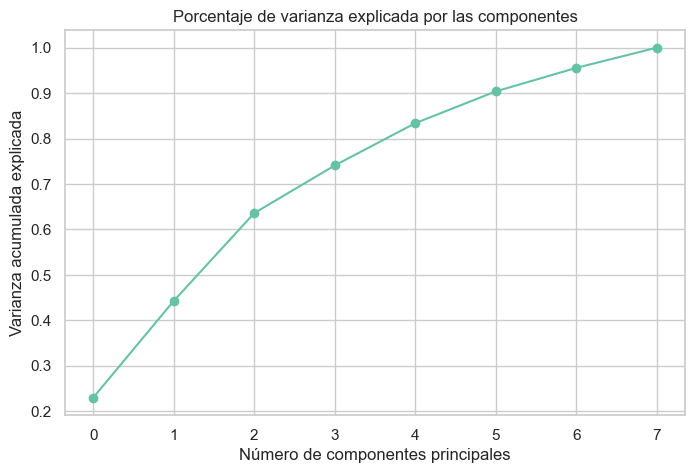

Varianza explicada por cada componente: [0.22972487 0.2128999  0.19321558 0.10495701 0.09302139 0.06994897
 0.05176451 0.04446778]
Varianza total acumulada: [0.22972487 0.44262477 0.63584035 0.74079736 0.83381875 0.90376772
 0.95553222 1.        ]


In [19]:
from sklearn.decomposition import PCA

# Creamos el modelo PCA (sin limitar componentes al principio)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada por cada componente
varianza = pca.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(varianza), marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Porcentaje de varianza explicada por las componentes')
plt.grid(True)
plt.show()

print("Varianza explicada por cada componente:", varianza)
print("Varianza total acumulada:", np.cumsum(varianza))


Analisis y evaluacion de tendencias y patrones

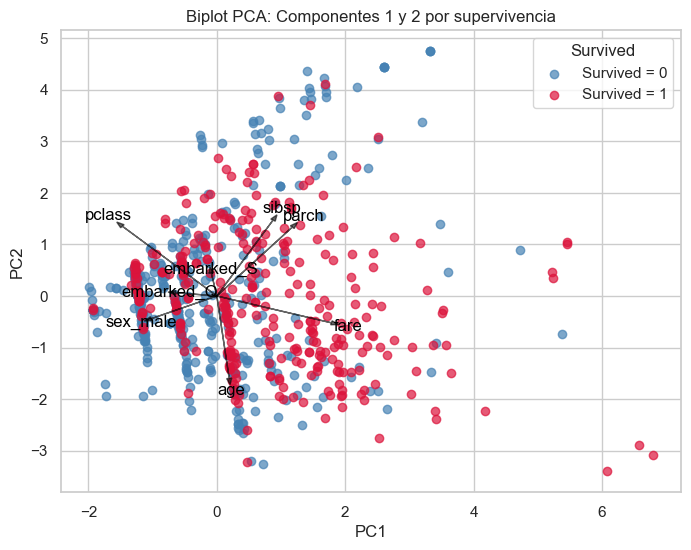

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# DataFrame con las componentes principales
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Agregamos la variable "survived" para comparar luego
pca_df['survived'] = df['survived'].values

# Colores fijos para cada grupo
colors = {0: 'steelblue', 1: 'crimson'}

plt.figure(figsize=(8,6))

# Graficamos cada grupo por separado
for s, color in colors.items():
    subset = pca_df[pca_df['survived'] == s]
    plt.scatter(subset['PC1'], subset['PC2'], 
                color=color, alpha=0.7, label=f'Survived = {s}')

# Flechas de las variables originales (cargas del PCA)
loadings = pca.components_.T[:, :2]  # tomamos PC1 y PC2
variables = df.drop(columns=['survived']).columns  # nombres de las variables originales

# Escalamos las flechas para que se vean bien
scaling_factor = 3
for i, var in enumerate(variables):
    plt.arrow(0, 0, 
            loadings[i, 0]*scaling_factor, 
            loadings[i, 1]*scaling_factor, 
            color='black', alpha=0.6, head_width=0.08)
    plt.text(loadings[i, 0]*scaling_factor*1.15, 
            loadings[i, 1]*scaling_factor*1.15, 
            var, color='black', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot PCA: Componentes 1 y 2 por supervivencia')
plt.legend(title='Survived')
plt.grid(True)
plt.show()


In [21]:
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(len(pca.components_))],
                        index=features)
loadings


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
pclass,-0.490594,0.451018,0.054902,-0.014703,0.143423,0.093109,-0.011931,0.723387
age,0.064201,-0.532793,-0.058585,0.090570,0.796622,-0.044733,-0.108462,0.228040
sibsp,0.291910,0.490382,0.006675,0.436766,0.213511,-0.634329,-0.177690,-0.063019
parch,0.391928,0.445127,0.009872,0.062221,0.347115,0.703287,-0.007400,-0.170676
fare,0.595067,-0.173428,0.092163,0.235522,-0.293093,0.042551,0.375702,0.568320
sex_male,-0.340246,-0.146568,-0.272240,0.832442,-0.134333,0.253350,0.044601,-0.107028
embarked_Q,-0.213737,0.021251,0.665293,0.126305,0.213040,-0.069017,0.626608,-0.229150
embarked_S,-0.028651,0.148630,-0.684243,-0.180449,0.171501,-0.146915,0.648603,-0.068230


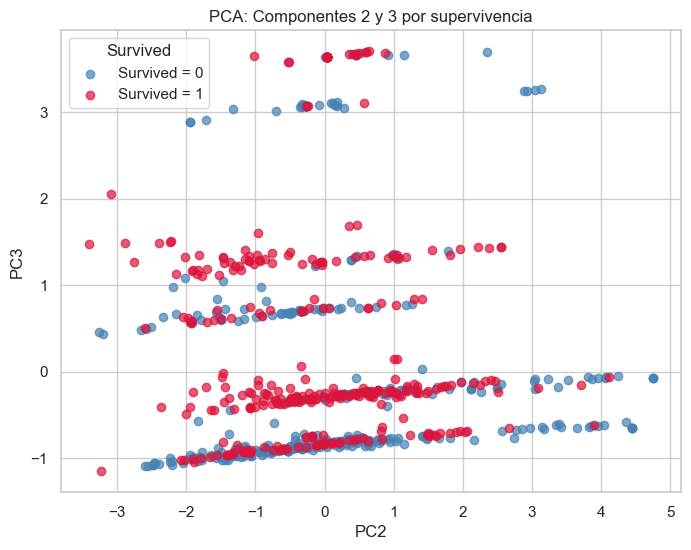

In [22]:
colors = {0: 'steelblue', 1: 'crimson'}

plt.figure(figsize=(8,6))

# Graficar los puntos diferenciando por supervivencia
for s, color in colors.items():
    subset = pca_df[pca_df['survived'] == s]
    plt.scatter(subset['PC2'], subset['PC3'], 
                color=color, alpha=0.7, label=f'Survived = {s}')

plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA: Componentes 2 y 3 por supervivencia')
plt.legend(title='Survived')
plt.grid(True)
plt.show()

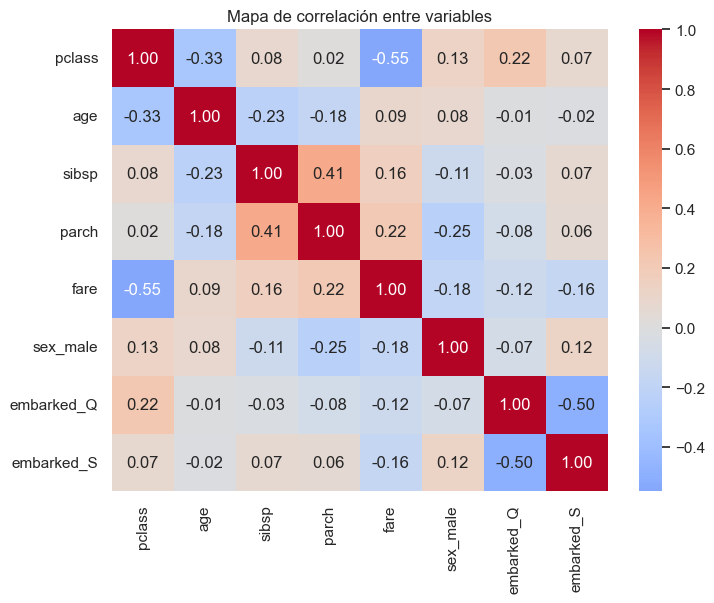

In [23]:
corr_matrix = df[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q', 'embarked_S']].corr()

# Crear el heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Mapa de correlación entre variables')
plt.show()